In [22]:
import warnings
from importlib import reload
from functools import partial, lru_cache
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm, trange
from joblib import delayed
from modAL import batch
from art.metrics import empirical_robustness
from art.attacks.evasion import *
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from tabulate import tabulate
from art.estimators.classification.scikitlearn import ScikitlearnSVC
from sklearn.metrics.pairwise import paired_distances, euclidean_distances
import scipy
from tvregdiff.tvregdiff import TVRegDiff

from ipynb.fs.defs import Bias
from ipynb.fs.defs.Datasets import generateData_twoPills_2D, generateData_twoPills_noNoise_2D, plot_dataset_2D

import libactive
import libadversarial
import libstop
from libactive import MyActiveLearner, active_split
from libadversarial import adversarial, uncertainty, random_batch, uncertainty_stop
from libutil import ProgressParallel
from libdatasets import *
import librun
from librun import run

In [4]:
matrix = {
    # Dataset fetchers should cache if possible
    # Lambda wrapper required for function to be pickleable (sent to other threads via joblib)
    "datasets": [
        ("bbbp", lambda: lru_cache()(bbbp)()),
        ("car", lambda: lru_cache()(car)()),
        ("mnist", lambda: lru_cache()(mnist)()),
        ("german", lambda: lru_cache()(german)()),
    ],
    "dataset_mutators": {
        "none": (lambda *x: x),
    },
    "methods": [
        ("uncertainty", partial(uncertainty_stop, n_instances=10)),
    ],
    "models": [
        "svm-linear"
    ],
    "meta": {
        "dataset_size": 1000,
        "labelled_size": 0.01,
        "n_runs": 10,
        "ret_classifiers": True,
        "ensure_y": True,
        "stop_info": True
    }
}

In [5]:
capture_metrics = [
    accuracy_score,
    f1_score,
    roc_auc_score,
    
    "uncertainty_average",
    "uncertainty_min",
    "uncertainty_max",
    "uncertainty_variance",
    "uncertainty_average_selected",
    "uncertainty_min_selected",
    "uncertainty_max_selected",
    "uncertainty_variance_selected",
    "entropy_max",
    "n_support",
    "contradictory_information",
    # slow
    #"expected_error"
]

In [6]:
results = librun.run(matrix, metrics=capture_metrics)
results_plots = [result[0] for result in results]
classifiers = [result[1] for result in results]
classifiers = [clf for clf in classifiers]

In [28]:
reload(libstop); from libstop import ZPS, uncertainty_min, n_support, optimal, optimal_ub, optimal_lb, optimal_fixed, SC_entropy_mcs, SC_oracle_acc_mcs, acc, first_acc, EVM, kappa, kappa_metric, no_ahead_tvregdiff, hyperplane_similarity

In [31]:
params = {
    "kappa": {"k": 2}
}
stop_conditions = {
    #f"{f.__name__}": partial(f, **params.get(f.__name__, {})) for f in [ZPS, uncertainty_min, n_support, optimal, optimal_ub, optimal_lb, SC_entropy_mcs, SC_oracle_acc_mcs, EVM, ]#kappa]
    f"{f.__name__}": partial(f, **params.get(f.__name__, {})) for f in [optimal_fixed, ZPS, uncertainty_min, n_support, SC_entropy_mcs, SC_oracle_acc_mcs, EVM,] #kappa]
}

In [32]:
stop_results = {}
for (clfs, (conf, metrics)) in zip(classifiers, results_plots):
    stop_results[conf.dataset_name] = {}
    for (name, cond) in stop_conditions.items():
        stop_results[conf.dataset_name][name] = [cond(**metrics, classifiers=clfs_) for clfs_ in clfs]

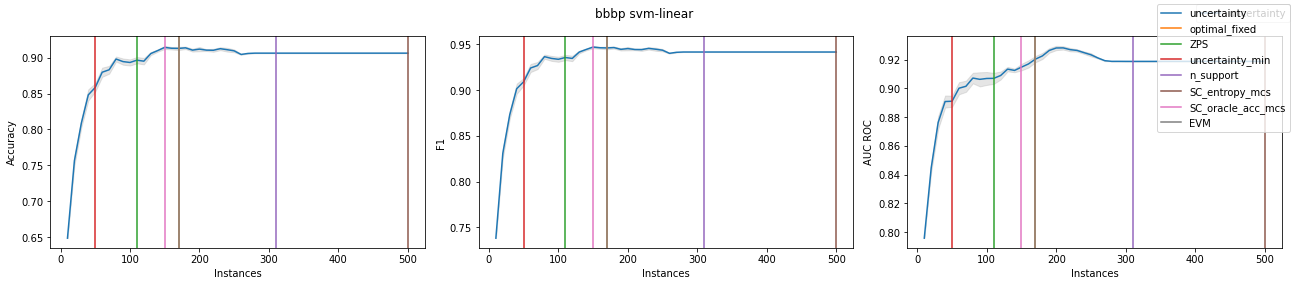

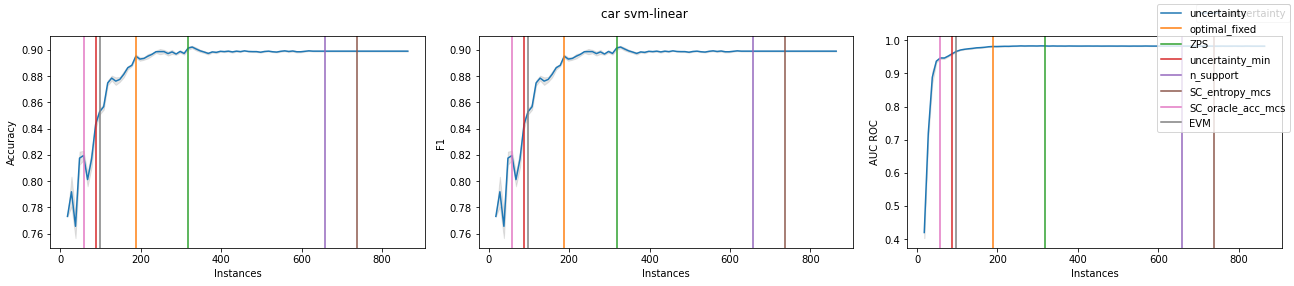

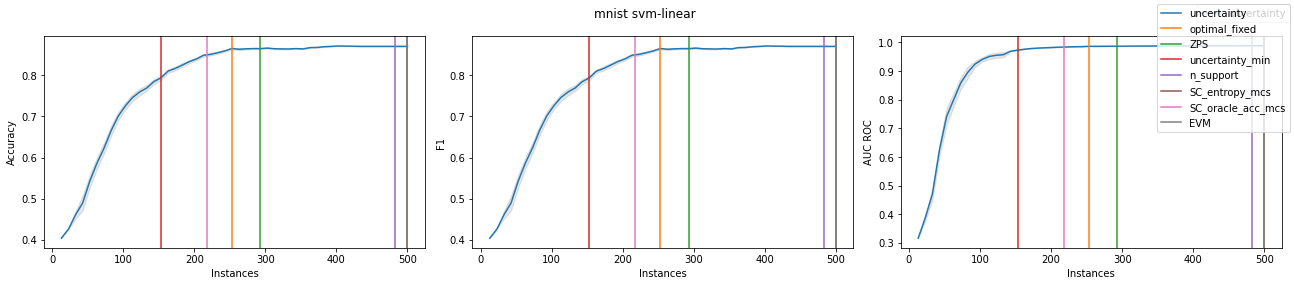

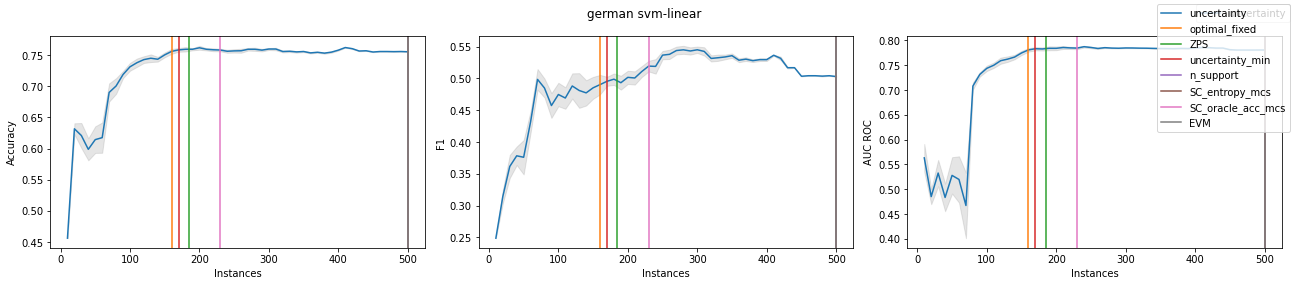

In [56]:
reload(libstop); reload(librun)
figaxes = librun.plot(results_plots, ret=True, sort=False)
for i, (fig, ax) in enumerate(figaxes):
    clfs = classifiers[i]
    metrics = results_plots[i][1]
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    
    for ii, a in enumerate(ax):        
        for iii, (name, cond) in enumerate(stop_conditions.items()):
            stops = stop_results[results_plots[i][0].dataset_name][name]
            a.axvline(np.median(stops), label=name if ii == 0 else None, color=colors[(iii+1)%len(colors)])
            #for iiii, stop in enumerate(stops):
            #    a.axvline(stop, label=name if ii == 0 and iiii ==0 else None, color=colors[(iii+1) % len(colors)])

    fig.legend()
    fig.tight_layout()

In [89]:
reload(libstop); from libstop import stopped_at, optimal_dist, in_bounds, instances, performance

In [36]:
stopped_at(stop_results)

╒════════╤═════════════════╤═══════════════╤═══════════════════╤═══════════════╤══════════════════╤═════════════════════╤═══════════════╕
│        │ optimal_fixed   │ ZPS           │ uncertainty_min   │ n_support     │ SC_entropy_mcs   │ SC_oracle_acc_mcs   │ EVM           │
╞════════╪═════════════════╪═══════════════╪═══════════════════╪═══════════════╪══════════════════╪═════════════════════╪═══════════════╡
│ bbbp   │ 170, 170, 170   │ 80, 110, 160  │ 50, 50, 50        │ 310, 310, 310 │ 500, 500, 500    │ 30, 150, 200        │ 170, 170, 170 │
├────────┼─────────────────┼───────────────┼───────────────────┼───────────────┼──────────────────┼─────────────────────┼───────────────┤
│ car    │ 188, 188, 188   │ 108, 318, 398 │ 88, 88, 88        │ 658, 658, 658 │ 738, 738, 738    │ 48, 58, 118         │ 98, 98, 98    │
├────────┼─────────────────┼───────────────┼───────────────────┼───────────────┼──────────────────┼─────────────────────┼───────────────┤
│ mnist  │ 253, 253, 253   │ 213, 

In [55]:
optimal_dist(stop_results, optimal='optimal_fixed')

╒════════╤══════════════════════╤════════════════════╤═════════════════════╤══════════════════════╤══════════════════════╤══════════════════════╕
│        │ ZPS                  │ uncertainty_min    │ n_support           │ SC_entropy_mcs       │ SC_oracle_acc_mcs    │ EVM                  │
╞════════╪══════════════════════╪════════════════════╪═════════════════════╪══════════════════════╪══════════════════════╪══════════════════════╡
│ bbbp   │ -90, -60, -10        │ -120, -120, -120   │ 140, 140, 140       │ 330, 330, 330        │ -140, -20, 30        │ 0, 0, 0              │
├────────┼──────────────────────┼────────────────────┼─────────────────────┼──────────────────────┼──────────────────────┼──────────────────────┤
│ car    │ -80, 130, 210        │ -100, -100, -100   │ 470, 470, 470       │ 550, 550, 550        │ -140, -130, -70      │ -90, -90, -90        │
├────────┼──────────────────────┼────────────────────┼─────────────────────┼──────────────────────┼──────────────────────┼──

In [93]:
performance(stop_results, results_plots, metric='roc_auc_score')

╒════════╤═════════════════╤═══════╤═══════════════════╤═════════════╤══════════════════╤═════════════════════╤═══════╕
│        │ optimal_fixed   │ ZPS   │ uncertainty_min   │ n_support   │ SC_entropy_mcs   │ SC_oracle_acc_mcs   │ EVM   │
╞════════╪═════════════════╪═══════╪═══════════════════╪═════════════╪══════════════════╪═════════════════════╪═══════╡
│ bbbp   │ 99%             │ 98%   │ 96%               │ 99%         │ 99%              │ 99%                 │ 99%   │
├────────┼─────────────────┼───────┼───────────────────┼─────────────┼──────────────────┼─────────────────────┼───────┤
│ car    │ 100%            │ 100%  │ 98%               │ 100%        │ 100%             │ 96%                 │ 98%   │
├────────┼─────────────────┼───────┼───────────────────┼─────────────┼──────────────────┼─────────────────────┼───────┤
│ mnist  │ 100%            │ 100%  │ 98%               │ 100%        │ 100%             │ 100%                │ 100%  │
├────────┼─────────────────┼───────┼────

In [91]:
performance(stop_results, results_plots, metric='accuracy_score')

╒════════╤═════════════════╤═══════╤═══════════════════╤═════════════╤══════════════════╤═════════════════════╤═══════╕
│        │ optimal_fixed   │ ZPS   │ uncertainty_min   │ n_support   │ SC_entropy_mcs   │ SC_oracle_acc_mcs   │ EVM   │
╞════════╪═════════════════╪═══════╪═══════════════════╪═════════════╪══════════════════╪═════════════════════╪═══════╡
│ bbbp   │ 100%            │ 98%   │ 94%               │ 99%         │ 99%              │ 100%                │ 100%  │
├────────┼─────────────────┼───────┼───────────────────┼─────────────┼──────────────────┼─────────────────────┼───────┤
│ car    │ 99%             │ 100%  │ 93%               │ 100%        │ 100%             │ 91%                 │ 95%   │
├────────┼─────────────────┼───────┼───────────────────┼─────────────┼──────────────────┼─────────────────────┼───────┤
│ mnist  │ 99%             │ 99%   │ 91%               │ 100%        │ 100%             │ 98%                 │ 100%  │
├────────┼─────────────────┼───────┼────

In [92]:
performance(stop_results, results_plots, metric='f1_score')

╒════════╤═════════════════╤═══════╤═══════════════════╤═════════════╤══════════════════╤═════════════════════╤═══════╕
│        │ optimal_fixed   │ ZPS   │ uncertainty_min   │ n_support   │ SC_entropy_mcs   │ SC_oracle_acc_mcs   │ EVM   │
╞════════╪═════════════════╪═══════╪═══════════════════╪═════════════╪══════════════════╪═════════════════════╪═══════╡
│ bbbp   │ 100%            │ 99%   │ 96%               │ 99%         │ 99%              │ 100%                │ 100%  │
├────────┼─────────────────┼───────┼───────────────────┼─────────────┼──────────────────┼─────────────────────┼───────┤
│ car    │ 99%             │ 100%  │ 93%               │ 100%        │ 100%             │ 91%                 │ 95%   │
├────────┼─────────────────┼───────┼───────────────────┼─────────────┼──────────────────┼─────────────────────┼───────┤
│ mnist  │ 99%             │ 99%   │ 91%               │ 100%        │ 100%             │ 98%                 │ 100%  │
├────────┼─────────────────┼───────┼────